# Estudio Mono-Compartimental farmacocin√©tico del Sunitinib + ketoconazol en ratones üß™üê≠

En este cuaderno se analiza el comportamiento farmacocin√©tico de una formulaci√≥n que contiene **sunitinib** combinado con **ketoconazol** en ratones.

Utilizamos un **modelo monocompartimental con absorci√≥n de primer orden** para describir la concentraci√≥n del f√°rmaco en distintos compartimentos: **Plasma**, **Cerebro**, **Ri√±√≥n** e **H√≠gado**.

### Objetivos
- Estimar los par√°metros: 
  - $k_e$: constante de eliminaci√≥n
  - $t_{1/2}$: vida media
  - $k_a$: constante de absorci√≥n
  - Factor de concentraci√≥n
- Calcular el error cuadr√°tico total (SSR) y el criterio de informaci√≥n de Akaike (AIC)
- Comparar los valores reales y predichos mediante gr√°ficas

In [158]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Cargar datos desde archivo
df = pd.read_csv('data.csv', index_col=0)
print(df)

         Cerebro    Plasma      Ri√±on      Higado
Tiempo                                           
0.00    0.000000  0.000000   0.000000    0.000000
0.08    2.375455  1.253699   7.725515   28.739378
0.25    2.428088  1.883693  17.777037   43.681615
0.50    2.473455  1.635242  22.042997   53.189255
1.00    3.671161  2.028957  35.874868   80.544272
2.00    4.597385  2.850109  66.188478  158.306083
4.00    6.108580  3.384569  64.424283  119.348789
6.00    4.235917  2.608140  53.622046   90.896761
8.00    2.888443  1.869260  39.509340   71.328054
12.00   2.103540  1.188970  19.110558   27.001372


## Funci√≥n `analizar_compartimento`

Esta funci√≥n estima los par√°metros cin√©ticos a partir de los datos experimentales de un compartimento dado.

Se realiza el siguiente flujo:

1. Se encuentra el tiempo al que se alcanza la concentraci√≥n m√°xima $C_{max}$ (es decir, $t_{max}$).
2. Se utiliza la fase terminal para ajustar una recta a \( \ln(C) \) y calcular:
   - $k_e = -\text{pendiente}$
   - $t_{1/2} = \frac{\ln(2)}{k_e}$
3. Se estima $k_a$ utilizando el **m√©todo de bisecci√≥n** con la ecuaci√≥n:

$$
\ln(x) = k_e \cdot (x - 1) \cdot t_{max}
$$

4. Se ajusta el modelo monocompartimental con absorci√≥n de primer orden:

$$
C(t) = F \cdot \left(e^{-k_e t} - e^{-k_a t} \right)
$$

Donde $F$ es un **factor de concentraci√≥n** calculado a partir de $C_{max}$, $k_e$, y $k_a$.

5. Se calcula el **SSR** y el **AIC** para evaluar el ajuste.

In [159]:
def analizar_compartimento(df, compartimento):
    df_comp = df[[compartimento]].copy()
    df_comp.columns = ['Concentraci√≥n']
    
    t_max = df_comp['Concentraci√≥n'].idxmax()
    c_max = df_comp.loc[t_max, 'Concentraci√≥n']
    
    df_terminal = df_comp.loc[t_max:].copy()
    tiempos_terminal = df_terminal.index.tolist()
    concentraciones_terminal = df_terminal['Concentraci√≥n'].tolist()
    ln_concentraciones = np.log(concentraciones_terminal)

    pendiente, _ = np.polyfit(tiempos_terminal, ln_concentraciones, 1)
    k_e = -pendiente
    t_mitad = np.log(2) / k_e

    def ecuacion(x, k_e, t_max):
        return math.log(x) - k_e * (x - 1) * t_max

    def resolver_ka(k_e, t_max, x_inf=1.01, x_sup=20.0, tol=1e-7):
        f_inf = ecuacion(x_inf, k_e, t_max)
        f_sup = ecuacion(x_sup, k_e, t_max)
        if f_inf * f_sup > 0:
            raise ValueError("No hay cambio de signo en el intervalo.")
        while (x_sup - x_inf) > tol:
            x_med = (x_inf + x_sup) / 2
            f_med = ecuacion(x_med, k_e, t_max)
            if f_med == 0:
                return x_med * k_e
            if f_inf * f_med < 0:
                x_sup = x_med
                f_sup = f_med
            else:
                x_inf = x_med
                f_inf = f_med
        return (x_inf + x_sup) / 2 * k_e

    k_a = resolver_ka(k_e, t_max)
    factor = c_max / (np.exp(-k_e * t_max) - np.exp(-k_a * t_max))

    def concentracion_predicha(t, factor=factor, k_a=k_a, k_e=k_e):
        return factor * (np.exp(-k_e * t) - np.exp(-k_a * t))

    df_comp['Predicho'] = df_comp.index.to_series().apply(concentracion_predicha)
    df_comp['Error'] = df_comp['Concentraci√≥n'] - df_comp['Predicho']
    df_comp['Error¬≤'] = df_comp['Error']**2

    ssr = df_comp['Error¬≤'].sum()
    p = 3
    n = len(df_comp) - 1
    aic = n * np.log(ssr / n) + 2 * p

    resultados = {
        'Comp': compartimento,
        'k_e (h^-1)': round(k_e, 4),
        't_¬Ω (h)': round(t_mitad, 2),
        'k_a (h^-1)': round(k_a, 4),
        'Factor': round(factor, 4),
        'SSR': round(ssr, 4),
        'AIC': round(aic, 4),
        'Dataframe': df_comp
    }

    return resultados

## Aplicaci√≥n del modelo a los compartimentos

Aplicamos la funci√≥n `analizar_compartimento` a los siguientes compartimentos:

- Plasma
- Cerebro
- Ri√±√≥n
- H√≠gado

Y mostramos los par√°metros estimados para cada uno.

In [160]:
compartimentos = ['Plasma', 'Cerebro', 'Ri√±on', 'Higado']
resultados_finales = {}

for comp in compartimentos:
    resultados_finales[comp] = analizar_compartimento(df, comp)

## Visualizaci√≥n de los modelos

Comparamos la concentraci√≥n real con la concentraci√≥n predicha por el modelo monocompartimental con absorci√≥n para cada compartimento.

Se espera que el modelo prediga adecuadamente la fase de absorci√≥n y eliminaci√≥n.

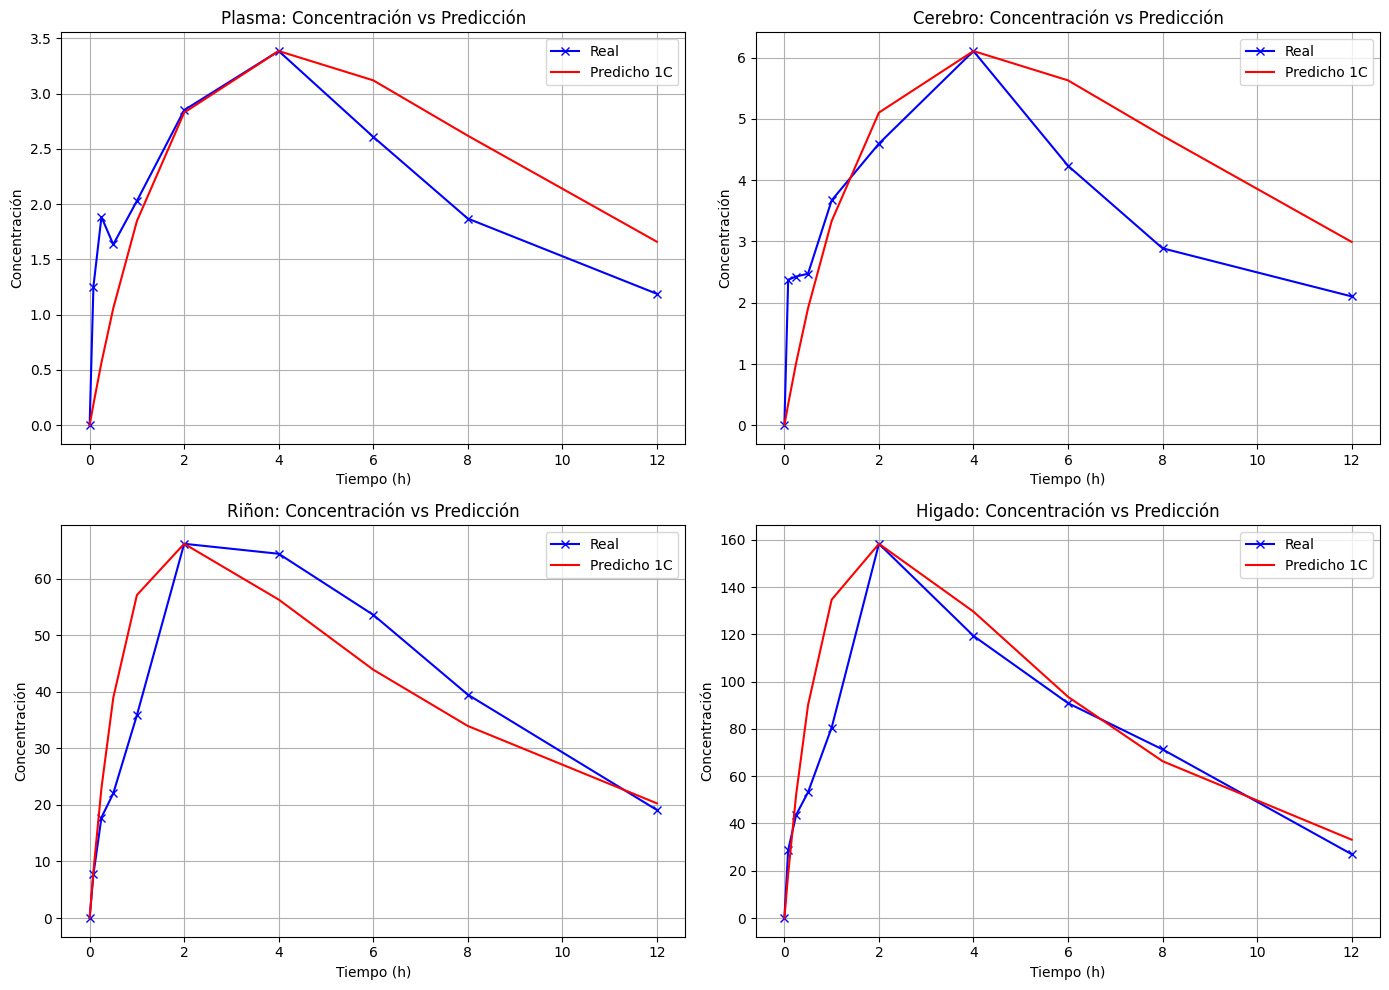

In [161]:
def graficar_todos_los_compartimentos(resultados):
    _, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()

    for i, (nombre, resultado) in enumerate(resultados.items()):
        df = resultado['Dataframe']
        axs[i].plot(df.index, df['Concentraci√≥n'], label='Real', marker='x', color='blue')
        axs[i].plot(df.index, df['Predicho'], label='Predicho 1C', color='red')
        axs[i].set_title(f'{nombre}: Concentraci√≥n vs Predicci√≥n')
        axs[i].set_xlabel('Tiempo (h)')
        axs[i].set_ylabel('Concentraci√≥n')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

graficar_todos_los_compartimentos(resultados_finales)

# Estudio Bi-Compartimental farmacocin√©tico del Sunitinib + ketoconazol en ratones üß™üê≠

Este an√°lisis se basa en un estudio farmacocin√©tico del f√°rmaco **sunitinib combinado con ketotomasapredatidonazol** administrado a ratones. El objetivo es ajustar un modelo bicompartimental con absorci√≥n para describir la cin√©tica del f√°rmaco en distintos tejidos (plasma, h√≠gado, ri√±√≥n y cerebro), y calcular par√°metros como:

- Tasa de absorci√≥n (`ka`)
- Tasas de eliminaci√≥n de los compartimentos (`alfa`, `beta`)
- Concentraci√≥n m√°xima (`Cmax`) y tiempo a la concentraci√≥n m√°xima (`Tmax`)
- √Årea bajo la curva hasta infinito (`AUC_inf`)
- Semivida terminal (`t‚ÇÅ/‚ÇÇ`)
- Depuraci√≥n aparente (`CL/F`)
- Volumen de distribuci√≥n aparente (`Vd/F`)
- Tiempo medio de residencia (`MRT`)

In [162]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import simpson
import matplotlib.pyplot as plt

In [163]:
# Cargar datos desde archivo CSV
df = pd.read_csv('data.csv', index_col=0)
print(df)

# Datos de tiempo (horas)
tiempos = np.array(df.index.tolist()[1:])

# Concentraciones por tejido
concentraciones = {
    'Plasma':  np.array(df["Plasma"].tolist()[1:]),
    'Higado':  np.array(df["Higado"].tolist()[1:]),
    'Ri√±on':   np.array(df["Ri√±on"].tolist()[1:]),
    'Cerebro': np.array(df["Cerebro"].tolist()[1:]),
}

         Cerebro    Plasma      Ri√±on      Higado
Tiempo                                           
0.00    0.000000  0.000000   0.000000    0.000000
0.08    2.375455  1.253699   7.725515   28.739378
0.25    2.428088  1.883693  17.777037   43.681615
0.50    2.473455  1.635242  22.042997   53.189255
1.00    3.671161  2.028957  35.874868   80.544272
2.00    4.597385  2.850109  66.188478  158.306083
4.00    6.108580  3.384569  64.424283  119.348789
6.00    4.235917  2.608140  53.622046   90.896761
8.00    2.888443  1.869260  39.509340   71.328054
12.00   2.103540  1.188970  19.110558   27.001372


## Modelo bicompartimental con absorci√≥n

El modelo describe la concentraci√≥n del f√°rmaco `C(t)` en funci√≥n del tiempo `t` mediante la siguiente ecuaci√≥n:

$$
C(t) = A \left(e^{-\alpha t} - e^{-k_a t} \right) + B \left(e^{-\beta t} - e^{-k_a t} \right)
$$

Donde:
- \( k_a \): constante de absorci√≥n
- \( A \), \( B \): coeficientes de distribuci√≥n
- \( \alpha \): tasa de distribuci√≥n (fase r√°pida)
- \( \beta \): tasa de eliminaci√≥n terminal (fase lenta)

In [164]:
def modelo_bicompartimental(t, ka, A, alfa, B, beta):
    return A * (np.exp(-alfa*t) - np.exp(-ka*t)) + B * (np.exp(-beta*t) - np.exp(-ka*t))

## Ajuste del modelo y c√°lculo de par√°metros farmacocin√©ticos

Se ajusta el modelo bicompartimental a los datos experimentales usando m√≠nimos cuadrados no lineales, y se calculan los siguientes par√°metros:

- **Cmax**: concentraci√≥n m√°xima predicha.
- **Tmax**: tiempo en el que ocurre Cmax.
- **AUC‚ÇÄ‚Äì‚àû**: √°rea bajo la curva desde 0 hasta infinito, usando:

$$
AUC_{0-\infty} = AUC_{0-12h} + \frac{C_{\text{last}}}{\beta}
$$

- **t‚ÇÅ/‚ÇÇ** (semivida terminal):

$$
t_{1/2} = \frac{\ln 2}{\beta}
$$

- **CL/F** (depuraci√≥n aparente):

$$
CL/F = \frac{D}{AUC_{0-\infty}} \quad \text{donde } D = 40 \, \mu g/kg
$$

- **Vd/F** (volumen de distribuci√≥n aparente):

$$
Vd/F = \frac{CL/F}{\beta}
$$

- **MRT** (tiempo medio de residencia):

$$
MRT = \frac{Vd/F}{CL/F}
$$

- **SE_{AUC_{0-\infty}}** (error est√°ndar del AUC extrapolado):

$$
SE_{AUC_{0-\infty}} = \frac{C_{\text{last}}}{\beta^2} \cdot SE_{\beta}
$$

- **SE_{CL/F}** (error est√°ndar de la depuraci√≥n aparente, por propagaci√≥n):

$$
SE_{CL/F} = \frac{D}{AUC_{0-\infty}^2} \cdot SE_{AUC_{0-\infty}}
$$

In [165]:
def ajustar_tejido(nombre, concentracion_tejido):
    p0 = [1.0, concentracion_tejido.max(), 1.0, concentracion_tejido.max()/2, 0.1]
    params, pcov = curve_fit(
        modelo_bicompartimental, 
        tiempos, concentracion_tejido, 
        p0=p0, bounds=(0, np.inf)
    )
    ka, A, alfa, B, beta = params

    t_fino = np.linspace(0, 12, 200)
    C_pred = modelo_bicompartimental(t_fino, *params)

    idx = np.argmax(C_pred)
    Cmax = C_pred[idx]
    Tmax = t_fino[idx]

    auc_0_12 = simpson(C_pred[t_fino <= 12], t_fino[t_fino <= 12])
    #auc_0_12 = simpson(modelo_bicompartimental(tiempos, *params), tiempos)
    Clast = C_pred[t_fino <= 12][-1]
    #Clast = modelo_bicompartimental(tiempos[-1], *params)
    auc_inf = auc_0_12 + Clast / beta

    t_mitad = np.log(2) / beta
    D = 40  # ¬µg/kg
    CL_sobre_F = D / auc_inf
    Vd_sobre_F = CL_sobre_F / beta
    MRT = Vd_sobre_F / CL_sobre_F

    # Error est√°ndar del AUC_inf (propagaci√≥n de incertidumbre simple considerando beta)
    se_beta = np.sqrt(np.diag(pcov))[4]  # √≠ndice 4 es beta
    se_auc_inf = Clast / (beta ** 2) * se_beta  # derivada parcial de Clast/beta respecto a beta
    se_auc_inf = Clast / (beta ** 2) * se_beta

    # Error est√°ndar del CL/F (por propagaci√≥n)
    se_CL_sobre_F = D / (auc_inf ** 2) * se_auc_inf


    return {
        'Tejido': nombre,
        'ka': ka, 'alfa': alfa, 'beta': beta,
        'Cmax': Cmax, 'Tmax': Tmax,
        'AUC_inf': auc_inf, 'SE_AUC_inf': se_auc_inf,
        't1/2': t_mitad,
        'CL/F': CL_sobre_F, 'SE_CL/F': se_CL_sobre_F,
        'Vd/F': Vd_sobre_F, 'MRT': MRT,
        "A": A, "B": B
    }

In [166]:
resultados_inhibidor = [ajustar_tejido(t, c) for t, c in concentraciones.items()]
df_inhibidor = pd.DataFrame(resultados_inhibidor).set_index('Tejido').round(3)
print(df_inhibidor)

            ka   alfa   beta     Cmax   Tmax   AUC_inf  SE_AUC_inf   t1/2  \
Tejido                                                                      
Plasma   1.140  1.141  0.098    3.185  2.352    40.922      17.022  7.069   
Higado   0.426  0.399  0.111  141.103  2.653  1273.524   22700.578  6.218   
Ri√±on    0.782  0.794  0.181   68.430  3.196   641.877      85.610  3.838   
Cerebro  0.800  0.800  0.130    5.550  2.714    60.887      19.471  5.349   

          CL/F  SE_CL/F   Vd/F     MRT         A        B  
Tejido                                                     
Plasma   0.977    0.407  9.969  10.199     0.475    4.390  
Higado   0.031    0.560  0.282   8.971  4669.783   72.466  
Ri√±on    0.062    0.008  0.345   5.537  4349.814  169.873  
Cerebro  0.657    0.210  5.070   7.717     0.753    9.416  


## Comparaci√≥n gr√°fica entre datos reales y predicci√≥n del modelo

En esta secci√≥n se grafican las concentraciones reales observadas y las curvas predichas por el modelo bicompartimental para cada tejido. Esto permite visualizar qu√© tan bien se ajusta el modelo a los datos experimentales.

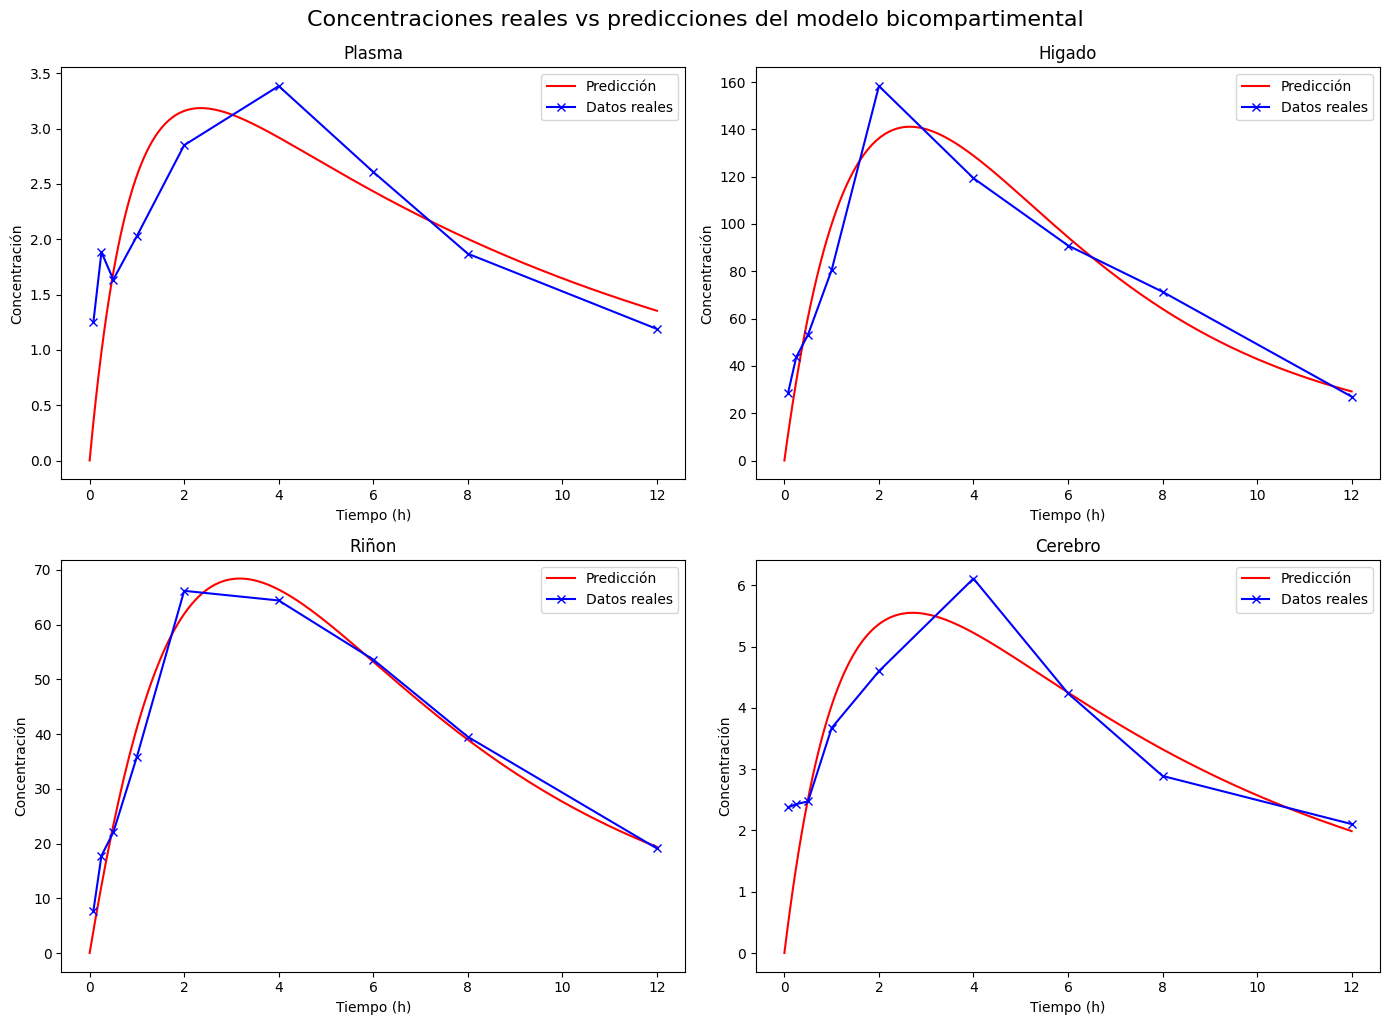

In [167]:
plt.figure(figsize=(14, 10))

for i, (nombre, concentracion_tejido) in enumerate(concentraciones.items()):
    p0 = [1.0, concentracion_tejido.max(), 1.0, concentracion_tejido.max()/2, 0.1]
    params, _ = curve_fit(modelo_bicompartimental, tiempos, concentracion_tejido, p0=p0, bounds=(0, np.inf))

    t_fino = np.linspace(0, 12, 200)
    C_pred = modelo_bicompartimental(t_fino, *params)

    plt.subplot(2, 2, i + 1)
    plt.plot(t_fino, C_pred, label='Predicci√≥n', color='red')
    plt.plot(tiempos, concentracion_tejido, label='Datos reales', marker='x', color='blue')
    plt.xlabel('Tiempo (h)')
    plt.ylabel('Concentraci√≥n')
    plt.title(nombre)
    plt.legend()

plt.tight_layout()
plt.suptitle('Concentraciones reales vs predicciones del modelo bicompartimental', fontsize=16, y=1.02)
plt.show()

# Conclusiones del estudio

En esta secci√≥n final de nuestro estudio, vamos a **evaluar cuantitativamente el ajuste de nuestros modelos** farmacocin√©ticos a los datos experimentales obtenidos de ratones tratados con sunitinib. Para ello, utilizaremos dos m√©tricas muy importantes:

- **SSR (Suma de los Cuadrados del Residuo)**: mide el error total entre los valores predichos por un modelo y los valores observados. Cuanto menor sea el SSR, mejor es el ajuste del modelo.

- **AIC (Criterio de Informaci√≥n de Akaike)**: eval√∫a la calidad de un modelo teniendo en cuenta tanto el ajuste a los datos como la complejidad del modelo (n√∫mero de par√°metros). Un AIC m√°s bajo indica un modelo m√°s eficiente.

Vamos a comparar **cuatro funciones modelo** y determinar cu√°l se ajusta mejor a nuestros datos reales.

## C√°lculo del SSR

El SSR (Suma de los Cuadrados del Residuo) se calcula usando la siguiente f√≥rmula:

$$
SSR = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Donde:

- $y_i$ son los valores reales.
- $\hat{y}_i$ son los valores predichos por el modelo.


In [168]:
def calcular_ssr(observados, predichos):
    return np.sum((observados - predichos) ** 2)

## C√°lculo del AIC

El AIC (Criterio de Informaci√≥n de Akaike) penaliza la complejidad del modelo. La f√≥rmula que usaremos es:

$$
AIC = n \cdot \ln\left(\frac{SSR}{n}\right) + 2k
$$

Donde:

- $n$: n√∫mero de observaciones.
- $SSR$: suma de los cuadrados de los residuos.
- $k$: n√∫mero de par√°metros del modelo.

Asumiremos lo siguiente para nuestros modelos:
- Modelo 1: 2 par√°metros
- Modelo 2: 3 par√°metros
- Modelo 3: 2 par√°metros
- Modelo 4: 4 par√°metros


In [169]:
def calcular_aic_bi(ssr, n, k=5):
    """
    Calcula el AIC para un modelo con 'k' par√°metros.
    Por defecto, el modelo bicompartimental tiene 5 par√°metros: A, B, alpha, beta, ka
    """
    return n * np.log(ssr / n) + 2 * k

## Conclusiones

In [170]:
resultados_df = []

for comp, res in resultados_finales.items():
    resultados_df.append({
        "Tejido": comp.upper(),
        "Modelo": "Monocompartimental",
        "SSR": res["SSR"],
        "AIC": res["AIC"]
    })

for i, (nombre, concentracion_tejido) in enumerate(concentraciones.items()):
    p0 = [1.0, concentracion_tejido.max(), 1.0, concentracion_tejido.max()/2, 0.1]
    params, _ = curve_fit(modelo_bicompartimental, tiempos, concentracion_tejido, p0=p0, bounds=(0, np.inf))

    C_pred = modelo_bicompartimental(tiempos, *params)
    ssr = calcular_ssr(concentracion_tejido, C_pred)
    aic = calcular_aic_bi(ssr, len(concentracion_tejido))

    resultados_df.append({
        "Tejido": nombre.upper(),
        "Modelo": "Bicompartimental",
        "SSR": ssr,
        "AIC": aic
    })

df_resultados = pd.DataFrame(resultados_df)
df_resultados = df_resultados.sort_values(by=["Tejido", "Modelo"])
df_resultados.set_index("Modelo", inplace=True)
print(df_resultados)

                     Tejido          SSR        AIC
Modelo                                             
Bicompartimental    CEREBRO     6.324883   6.825402
Monocompartimental  CEREBRO    12.903700   9.242600
Bicompartimental     HIGADO  1485.013923  55.953594
Monocompartimental   HIGADO  4641.323000  62.209800
Bicompartimental     PLASMA     2.322398  -2.191619
Monocompartimental   PLASMA     4.276900  -0.695900
Bicompartimental      RI√ëON    94.974923  31.207495
Monocompartimental    RI√ëON   956.999700  47.999200


Al comparar los modelos farmacocin√©ticos mono y bicompartimental en diferentes tejidos (cerebro, h√≠gado, plasma y ri√±√≥n), se observa que el modelo bicompartimental proporciona un mejor ajuste general a los datos. Esto se evidencia tanto por los valores m√°s bajos de **Suma de los Cuadrados de los Residuos (SSR)** como por los **criterios de informaci√≥n de Akaike (AIC)** m√°s reducidos en todos los tejidos evaluados. En particular, las diferencias son m√°s marcadas en tejidos como el h√≠gado y el ri√±√≥n, donde el modelo bicompartimental reduce significativamente el error de ajuste en comparaci√≥n con el monocompartimental. Estos resultados sugieren que el comportamiento farmacocin√©tico del compuesto estudiado se describe mejor con un enfoque bicompartimental, reflejando posiblemente una distribuci√≥n m√°s compleja en los tejidos analizados.

# Aplicar modelo Bi-Compartimental sobre los datos de Test

In [171]:
# Cargar datos desde archivo CSV
df = pd.read_csv('test.csv', index_col=0)
print(df)

# Datos de tiempo (horas)
tiempos = np.array(df.index.tolist()[1:])

# Concentraciones por tejido
concentraciones = {
    'Plasma':  np.array(df["Plasma"].tolist()[1:]),
    'Higado':  np.array(df["Higado"].tolist()[1:]),
    'Ri√±on':   np.array(df["Ri√±on"].tolist()[1:]),
    'Cerebro': np.array(df["Cerebro"].tolist()[1:]),
}

         Cerebro    Plasma     Higado       Ri√±on
Tiempo                                           
0.00    0.010000  0.010000   0.010000    0.010000
0.08    1.478175  0.761520   5.620105   27.757062
0.25    1.542916  1.140623  13.975576   49.453853
0.50    2.860693  2.716908  65.792679  107.025753
1.00    2.118253  1.732809  33.339625   78.384621
2.00    2.117737  1.967675  37.041934   68.008447
4.00    2.117785  1.238243  30.133649   36.716059
6.00    2.025212  1.056993  21.450501   27.188582
8.00    1.752101  0.964013  14.368102   15.055364
12.00   1.468479  0.714241   9.960894    5.880010


In [172]:
resultados_control = [ajustar_tejido(t, c) for t, c in concentraciones.items()]
df_control = pd.DataFrame(resultados_control).set_index('Tejido').round(3)
print(df_control)

            ka   alfa   beta    Cmax   Tmax  AUC_inf  SE_AUC_inf    t1/2  \
Tejido                                                                     
Plasma   2.245  2.202  0.087   2.225  0.724   22.019       8.047   7.932   
Higado   2.102  1.840  0.121  45.624  0.844  359.293     144.925   5.725   
Ri√±on    2.040  2.023  0.213  92.700  0.724  427.977      28.970   3.256   
Cerebro  7.039  1.957  0.036   2.381  0.603   65.727      45.382  19.386   

          CL/F  SE_CL/F    Vd/F     MRT          A       B  
Tejido                                                      
Plasma   1.817    0.664  20.788  11.443    133.456   1.898  
Higado   0.111    0.045   0.920   8.260    331.606  43.277  
Ri√±on    0.093    0.006   0.439   4.697  13162.078  89.006  
Cerebro  0.609    0.420  17.020  27.967      0.368   2.357  


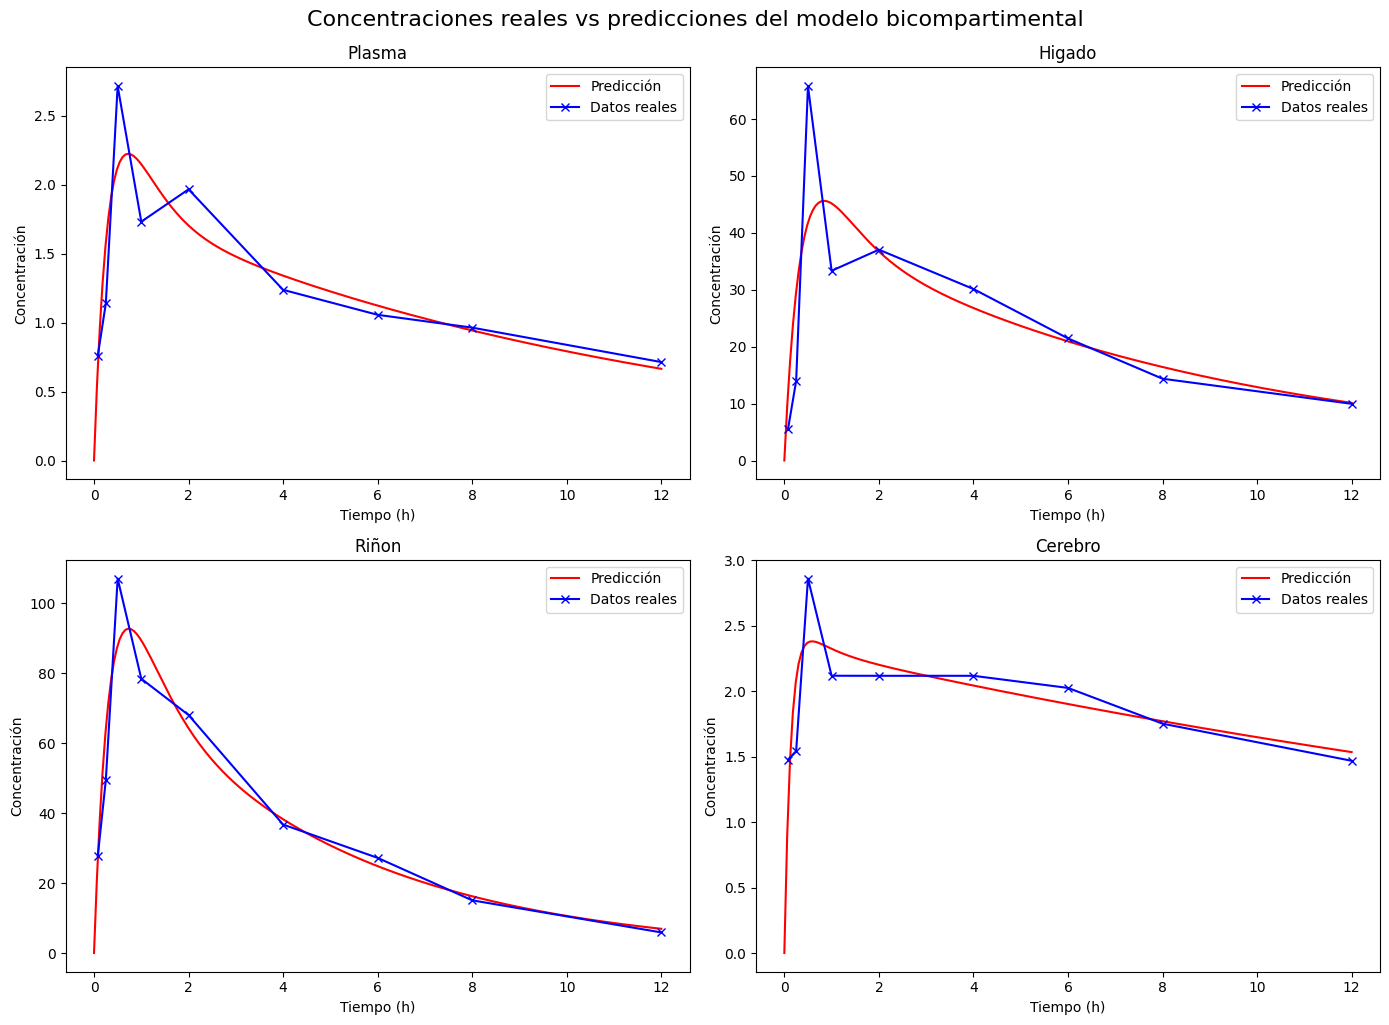

In [173]:
plt.figure(figsize=(14, 10))

for i, (nombre, concentracion_tejido) in enumerate(concentraciones.items()):
    p0 = [1.0, concentracion_tejido.max(), 1.0, concentracion_tejido.max()/2, 0.1]
    params, _ = curve_fit(modelo_bicompartimental, tiempos, concentracion_tejido, p0=p0, bounds=(0, np.inf))

    t_fino = np.linspace(0, 12, 200)
    C_pred = modelo_bicompartimental(t_fino, *params)

    plt.subplot(2, 2, i + 1)
    plt.plot(t_fino, C_pred, label='Predicci√≥n', color='red')
    plt.plot(tiempos, concentracion_tejido, label='Datos reales', marker='x', color='blue')
    plt.xlabel('Tiempo (h)')
    plt.ylabel('Concentraci√≥n')
    plt.title(nombre)
    plt.legend()

plt.tight_layout()
plt.suptitle('Concentraciones reales vs predicciones del modelo bicompartimental', fontsize=16, y=1.02)
plt.show()

# An√°lisis de diferencias de AUC usando el Test de Yuan

En este an√°lisis comparamos los valores de **AUC_inf** entre un grupo **control** y un grupo **inhibidor** utilizando el **Test de Yuan**, considerando la varianza en **CL/F** (Clearance/F).

## Funciones utilizadas

### Calcular la varianza del AUC_inf

La f√≥rmula para la varianza de AUC es:

$$
\text{Var}(AUC) = \frac{\text{dosis}^2 \times \text{Var}(CL/F)}{(CL/F)^4}
$$

donde:

- $\text{Var}(CL/F) = (SE_{CL/F})^2$



In [177]:
def calcular_varianza_auc(dosis, CL, SE_CL):
    var_CL = SE_CL ** 2
    var_AUC = (dosis ** 2 * var_CL) / (CL ** 4)
    return var_AUC, var_CL

### Test de Yuan para comparar AUC_inf

El estad√≠stico de prueba \(Z\) se calcula como:

$$
Z = \frac{AUC_{\text{control}} - AUC_{\text{inhibidor}}}{\sqrt{\frac{\text{Var}(AUC_{\text{control}})}{n_{\text{control}}} + \frac{\text{Var}(AUC_{\text{inhibidor}})}{n_{\text{inhibidor}}}}}
$$

El valor p (p-value) se calcula como:

$$
p\text{-value} = 2 \times \text{P}(Z > |z|)
$$



In [ ]:
from scipy.stats import norm
def yuan_test(control_auc, control_var, inhibitor_auc, inhibitor_var, n_control, n_inhibitor):
    se_combined = np.sqrt((control_var / n_control) + (inhibitor_var / n_inhibitor))
    z_stat = (control_auc - inhibitor_auc) / se_combined
    p_value = 2 * norm.sf(np.abs(z_stat))
    return z_stat, p_value

In [187]:
dosis = 40  # Dosis administrada
n_control = 4  # N√∫mero de animales en el grupo control
n_inhibitor = 4  # N√∫mero de animales en el grupo inhibidor

resultados = {}

for tejido in df_control.index:
    # Valores para control
    auc_c = df_control.loc[tejido, 'AUC_inf']
    cl_c = df_control.loc[tejido, 'CL/F']
    se_cl_c = df_control.loc[tejido, 'SE_CL/F']
    var_auc_c, var_cl_c = calcular_varianza_auc(dosis, cl_c, se_cl_c)

    # Valores para inhibidor
    auc_i = df_inhibidor.loc[tejido, 'AUC_inf']
    cl_i = df_inhibidor.loc[tejido, 'CL/F']
    se_cl_i = df_inhibidor.loc[tejido, 'SE_CL/F']
    var_auc_i, var_cl_i = calcular_varianza_auc(dosis, cl_i, se_cl_i)

    # Guardar resultados
    resultados[tejido] = {
        'AUC_Control': auc_c,
        'Var_CL_Control': var_cl_c,
        'AUC_Inhibidor': auc_i,
        'Var_CL_Inhibidor': var_cl_i,
        
    }

resultados_df = pd.DataFrame(resultados).T

In [ ]:
# ------------------------------------------------------------
# 1) Renombramos las columnas de varianza (opcional, solo por claridad)
# ------------------------------------------------------------
df = resultados_df.rename(
    columns={
        "Var_CL_Control":   "Var_AUC_Control",
        "Var_CL_Inhibidor": "Var_AUC_Inhibidor",
    }
)

# ------------------------------------------------------------
# 2) Par√°metros del experimento
# ------------------------------------------------------------
n_control = n_inhibitor = 4   # n√∫mero de animales en cada grupo

# ------------------------------------------------------------
# 3) Aplicamos la funci√≥n fila a fila
# ------------------------------------------------------------
(
    df[["Z", "p-value"]]  # columnas que vamos a crear
    # obtenemos dos columnas a la vez a partir de la tupla devuelta
) = df.apply(
    lambda row: yuan_test(
        row["AUC_Control"],
        row["Var_AUC_Control"],
        row["AUC_Inhibidor"],
        row["Var_AUC_Inhibidor"],
        n_control,
        n_inhibitor,
    ),
    axis=1,
    result_type="expand",   # para que devuelva dos columnas
)

# ------------------------------------------------------------
# 4) Columna de significancia
# ------------------------------------------------------------
df["Significativo"] = np.where(df["p-value"] < 0.05, "S√≠", "No")

# ------------------------------------------------------------
# 5) Redondeo y selecci√≥n de columnas de salida
# ------------------------------------------------------------
cols_redondear = [
    "AUC_Control",
    "Var_AUC_Control",
    "AUC_Inhibidor",
    "Var_AUC_Inhibidor",
    "Z",
    "p-value",
]
df[cols_redondear] = df[cols_redondear].round(6)

resultado = df[
    [
        "AUC_Control",
        "Var_AUC_Control",
        "AUC_Inhibidor",
        "Var_AUC_Inhibidor",
        "Z",
        "p-value",
        "Significativo",
    ]
]

print(resultado)


         AUC_Control  Var_AUC_Control  AUC_Inhibidor  Var_AUC_Inhibidor  \
Plasma        22.019         0.440896         40.922           0.165649   
Higado       359.293         0.002025       1273.524           0.313600   
Ri√±on        427.977         0.000036        641.877           0.000064   
Cerebro       65.727         0.176400         60.887           0.044100   

                    Z  p-value Significativo  
Plasma     -48.543291      0.0            S√≠  
Higado   -3254.619643      0.0            S√≠  
Ri√±on   -42780.000000      0.0            S√≠  
Cerebro     20.614417      0.0            S√≠  


## Interpretaci√≥n

- Si el valor **p < 0.05**, se considera que hay una diferencia estad√≠sticamente significativa en los valores de AUC_inf entre el grupo control y el grupo inhibidor para ese tejido.
- El **estad√≠stico Z** indica cu√°ntas desviaciones est√°ndar separan los valores de AUC entre los grupos.

Se compararon los valores de AUC entre **Control** e **Inhibidor**. Todos los cambios fueron **estad√≠sticamente significativos (p = 0.0)**, lo que implica un **efecto real del inhibidor** sobre la farmacocin√©tica en cada tejido.

| Tejido   | Efecto del Inhibidor | Implicaci√≥n |
|----------|-----------------------|-------------|
| **Plasma**   | ‚Üë AUC                  | Mayor exposici√≥n sist√©mica, el inhibidor podr√≠a reducir el aclaramiento. |
| **H√≠gado**   | ‚Üë‚Üë AUC                | Acumulaci√≥n hep√°tica marcada, posible inhibici√≥n del metabolismo hep√°tico. |
| **Ri√±√≥n**    | ‚Üë AUC                  | Mayor retenci√≥n renal, podr√≠a afectar la excreci√≥n. |
| **Cerebro**  | ‚Üì AUC                  | Menor penetraci√≥n al SNC, el inhibidor podr√≠a estar bloqueando el paso a trav√©s de la barrera hematoencef√°lica. |